In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os 
import random
import joblib
import torch
import gc

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    precision_score,
    recall_score,
    average_precision_score,
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_poisson_deviance
)

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.data.load_data import load_data
from scipy.stats import randint, uniform

from src.models.MLP_torch import MLP, train_model
from src.models.Poisson_statsmodels import poisson_model
from src.models.Classifier_sklearn import RFC
from src.utils.tuning import run_random_search
from src.utils.evaluation import eval_regressor_model, logclaim_to_claimrate
from src.visualization.model_plots import plot_epoch_rmse, tail_residuals_plot, prediction_distribution, prediction_distribution_violin, parity_plot, residual_plot,  plot_learning_curve
from sklearn.model_selection import RandomizedSearchCV, KFold


In [27]:
DT_scratch = joblib.load("../models/best_DT_scratch_model.joblib")
DT_sklearn = joblib.load("../models/best_DT_sklearn_model.joblib")

MLP_scratch = joblib.load("../models/best_mlp_scratch_model.joblib")
checkpoint = torch.load("../models/best_mlp_pytorch_model.pt")
MLP_pytorch = MLP(
    input_size=checkpoint["input_size"],
    hidden_sizes=checkpoint["hidden_sizes"]
)
MLP_pytorch.load_state_dict(checkpoint["model_state_dict"])
MLP_pytorch.eval()

RFC_model = joblib.load("../models/final_rfc.joblib")
NB_GLM = joblib.load("../models/final_nb_glm.joblib")
NB_GLM_PD = joblib.load("../models/final_nb_glm_pd.joblib")

models = {
    "DT scratch": DT_scratch,
    "DT sklearn": DT_sklearn,
    "MLP pytorch": MLP_pytorch,
    "NB-GLM": NB_GLM,
    "NB-GLM (PD)": NB_GLM_PD
}

In [20]:
target = "log_ClaimRate"

(X_train, y_train_log), (X_test, y_test_log)= load_data(raw=False, target=target)

y_train = np.expm1(y_train_log)
y_test = np.expm1(y_test_log)

target = "binary"

target = "BinaryClaim"

(_, y_train_bin), (_, y_test_bin)= load_data(raw=False, target=target)

In [24]:
def regression_metrics(y_true, y_pred):
    return {
        "RMSE": root_mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        #"Possion_deviance": mean_poisson_deviance(y_true, y_pred)
    }

In [22]:
def predict_model(model, X):
    # scratch model wrapped in dict
    if isinstance(model, dict) and "model" in model:
        model = model["model"]

    # PyTorch model
    if isinstance(model, torch.nn.Module):
        model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32)
            return model(X_tensor).numpy().squeeze()

    # sklearn or scratch DT
    return model.predict(X)

In [30]:
from sklearn.metrics import mean_poisson_deviance

results = []

for name, model in models.items():
    y_pred = predict_model(model, X_test)
    
    # if trained on log scale (skip NB models which are on raw scale)
    if "NB" not in name:
        y_pred = np.expm1(y_pred)
    
    # Compute standard regression metrics
    metrics = regression_metrics(y_test, y_pred)
    
    # Add Poisson deviance only for NB models
    if "NB" in name:
        poisson_dev = mean_poisson_deviance(y_test, y_pred)
        metrics["Poisson Dev."] = poisson_dev
    else:
        metrics["Poisson Dev."] = np.nan  # placeholder
    
    metrics["Model"] = name
    results.append(metrics)
    
    # Print percentiles for diagnostic purposes
    print(name, np.percentile(np.abs(y_test - y_pred), [50, 90, 99]))

# Build DataFrame
df_reg = pd.DataFrame(results).set_index("Model")
print(df_reg.round(4))


DT scratch [0.         0.         4.16666667]
DT sklearn [0.04431456 0.12818723 4.03897205]
MLP pytorch [1.05403256 1.1181813  3.01886293]
NB-GLM [0.19466731 0.52051342 3.86002286]
NB-GLM (PD) [0.19214946 0.52005574 3.86235329]
               RMSE     MAE  Poisson Dev.
Model                                    
DT scratch   3.0429  0.2411           NaN
DT sklearn   3.0349  0.2971           NaN
MLP pytorch  3.1398  1.1991           NaN
NB-GLM       3.0286  0.4507        1.8784
NB-GLM (PD)  3.0286  0.4489        1.8785


In [31]:
# Round numbers for LaTeX
df_reg_rounded = df_reg.round(4)

# Export to LaTeX
df_reg_rounded.to_latex(
    "regression_results.tex",
    caption="Comparison of regression models on claim rate prediction. RMSE and MAE are reported for all models. Poisson deviance is reported only for NB-GLM models.",
    label="tab:regression_results",
    na_rep="-",
    float_format="%.4f"
)

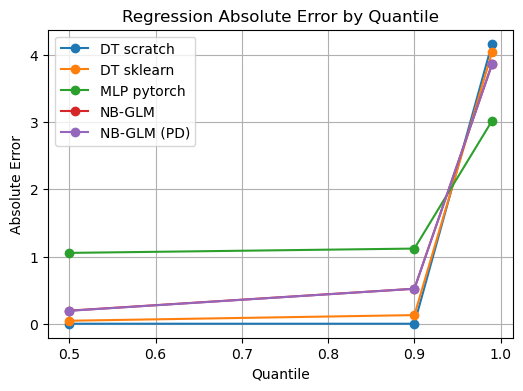

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
quantiles = [0.5, 0.9, 0.99]

for name, model in models.items():
    y_pred = predict_model(model, X_test)
    if "NB" not in name:
        y_pred = np.expm1(y_pred)
    
    errors = np.abs(y_test - y_pred)
    plt.plot(quantiles, np.quantile(errors, quantiles), marker='o', label=name)

plt.xlabel("Quantile")
plt.ylabel("Absolute Error")
plt.title("Regression Absolute Error by Quantile")
plt.legend()
plt.grid(True)
plt.show()


Random Forest Classifier — AUC: 0.6531, Accuracy: 0.7619, Precision: 0.0933, F1 Score: 0.1663


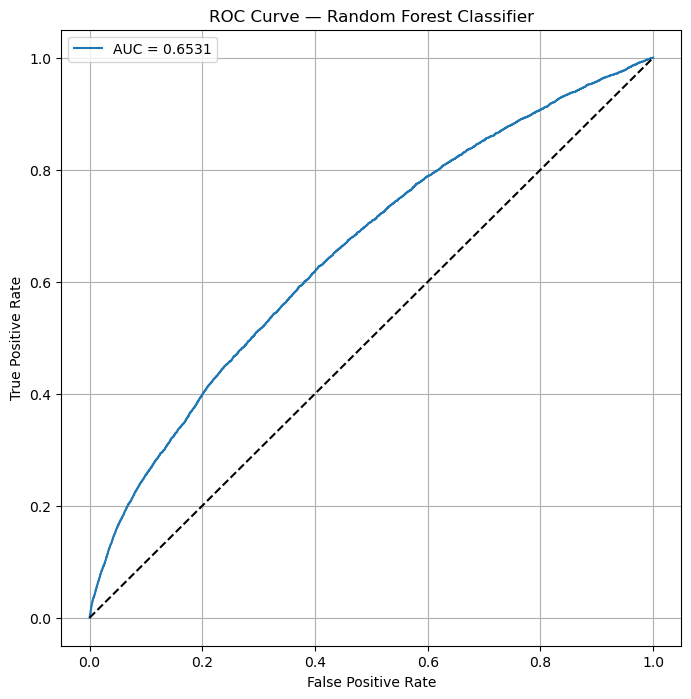

In [35]:
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt

# Predicted probabilities for the positive class
y_pred_proba = RFC_model.predict_proba(X_test)
y_pred_label = RFC_model.predict(X_test)

# Metrics
auc = roc_auc_score(y_test_bin, y_pred_proba)
acc = accuracy_score(y_test_bin, y_pred_label)
prc = precision_score(y_test_bin, y_pred_label)
f1 = 2 * (prc * acc) / (prc + acc)
print(f"Random Forest Classifier — AUC: {auc:.4f}, Accuracy: {acc:.4f}, Precision: {prc:.4f}, F1 Score: {f1:.4f}")

# ROC curve
fpr, tpr, _ = roc_curve(y_test_bin, y_pred_proba)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Random Forest Classifier")
plt.legend()
plt.grid()
plt.savefig("../images/rfc_roc_curve.png", dpi=300)
plt.show()


In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)
plot_learning_curve(best_model_MLP, X_train, y_train, cv=cv, name=name)